In [1]:
# Step 1: Import Libraries and Load Dataset
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from tqdm import tqdm  # Import tqdm for progress bar

# Load the dataset
file_path = 'Teacher_3026_CDATutterances_with_ICA_clusters.csv'
df = pd.read_csv(file_path)

# Encode the 'ut' and 'speaker' columns
le_ut = LabelEncoder()
df['ut'] = le_ut.fit_transform(df['ut'])

le_speaker = LabelEncoder()
df['speaker'] = le_speaker.fit_transform(df['speaker'])

In [2]:
#Step 2: Split Data into Training and Testing Sets
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df[['utterance', 'speaker', 'KMeans_Cluster']],
    df['ut'], test_size=0.2, random_state=42)

In [3]:
# Step 3: Initialize BERT tokenizer
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the utterances and pad sequences to max length 128
train_encodings = tokenizer(X_train['utterance'].tolist(), truncation=True, padding='max_length', max_length=128)
test_encodings = tokenizer(X_test['utterance'].tolist(), truncation=True, padding='max_length', max_length=128)

# Convert encodings to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(train_encodings), X_train['speaker'], X_train['KMeans_Cluster'], y_train)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(test_encodings), X_test['speaker'], X_test['KMeans_Cluster'], y_test)).batch(16)

In [4]:
# Step 4: Define a Custom BERT Layer with get_config
class CustomBertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(CustomBertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        bert_outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        return bert_outputs.last_hidden_state

    def get_config(self):
        config = super().get_config()
        config.update({"bert_model": self.bert_model})
        return config

# Load the BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
custom_bert_layer = CustomBertLayer(bert_model)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [5]:
# Step 5: Define the custom neural network with BERT embeddings
# Define the custom neural network with BERT embeddings
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
speaker_input = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='speaker_input')
em_cluster_input = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='em_cluster_input')

bert_outputs = custom_bert_layer([input_ids, attention_mask])
cls_token = bert_outputs[:, 0, :]

# Embedding layer for speaker input
speaker_embedding = tf.keras.layers.Embedding(input_dim=len(le_speaker.classes_), output_dim=16)(speaker_input)
speaker_embedding = tf.keras.layers.Flatten()(speaker_embedding)

# Embedding layer for EM_Cluster input
em_cluster_embedding = tf.keras.layers.Embedding(input_dim=df['KMeans_Cluster'].nunique(), output_dim=16)(em_cluster_input)
em_cluster_embedding = tf.keras.layers.Flatten()(em_cluster_embedding)

# Concatenate BERT output with speaker embedding and EM_Cluster embedding
concat = tf.keras.layers.Concatenate()([cls_token, speaker_embedding, em_cluster_embedding])
x = tf.keras.layers.Dense(128, activation='relu')(concat)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(len(le_ut.classes_), activation='softmax')(x)

model = tf.keras.models.Model(inputs=[input_ids, attention_mask, speaker_input, em_cluster_input], outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Step 6: Prepare the datasets with speaker inputs and cluster dimensions
train_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(train_encodings), X_train['speaker'], X_train['KMeans_Cluster'], y_train)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(test_encodings), X_test['speaker'], X_test['KMeans_Cluster'], y_test)).batch(16)

# Define a mapping function to combine the inputs
def map_fn(input_dict, speaker, em_cluster, labels):
    input_dict['speaker_input'] = speaker
    input_dict['em_cluster_input'] = em_cluster
    return input_dict, labels

train_dataset = train_dataset.map(map_fn)
test_dataset = test_dataset.map(map_fn)

# Train the model and save history
start_time = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=[early_stopping])

training_time = time.time() - start_time

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.0980 - loss: 2.4935 - val_accuracy: 0.1770 - val_loss: 2.0990
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.2391 - loss: 2.1699 - val_accuracy: 0.3982 - val_loss: 1.9611
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.3064 - loss: 2.0372 - val_accuracy: 0.4425 - val_loss: 1.8728
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.3491 - loss: 1.8968 - val_accuracy: 0.4513 - val_loss: 1.8069
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - accuracy: 0.4259 - loss: 1.7920 - val_accuracy: 0.4779 - val_loss: 1.7544
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.4676 - loss: 1.7516 - val_accuracy: 0.4779 - val_loss: 1.7089
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.4469 - loss: 1.7433 - val_accuracy: 0.4779 - val_loss: 1.6699
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.4423 - loss: 1.7119 - val_accuracy: 0.4867 - val_

In [7]:
# Step 7: Evaluate the model
eval_results = model.evaluate(test_dataset)

# Predict on the test set
predictions = model.predict(test_dataset)
pred_labels = np.argmax(predictions, axis=1)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, pred_labels)
precision = precision_score(y_test, pred_labels, average='weighted')
recall = recall_score(y_test, pred_labels, average='weighted')
f1 = f1_score(y_test, pred_labels, average='weighted')

# Generate a table with model parameters and performance indicators
model_summary = {
    'Parameter': ['Training Time (s)', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score', 'Test Loss'],
    'Value': [training_time, accuracy, precision, recall, f1, eval_results[0]]
}

df_summary = pd.DataFrame(model_summary)
print("Model Summary:")
print(df_summary)

8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.5191 - loss: 1.5578
8/8 ━━━━━━━━━━━━━━━━━━━━ 181s 18s/step
Model Summary:
           Parameter        Value
0  Training Time (s)  1276.926442
1      Test Accuracy     0.522124
2     Test Precision     0.318265
3        Test Recall     0.522124
4      Test F1 Score     0.394548
5          Test Loss     1.570698


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


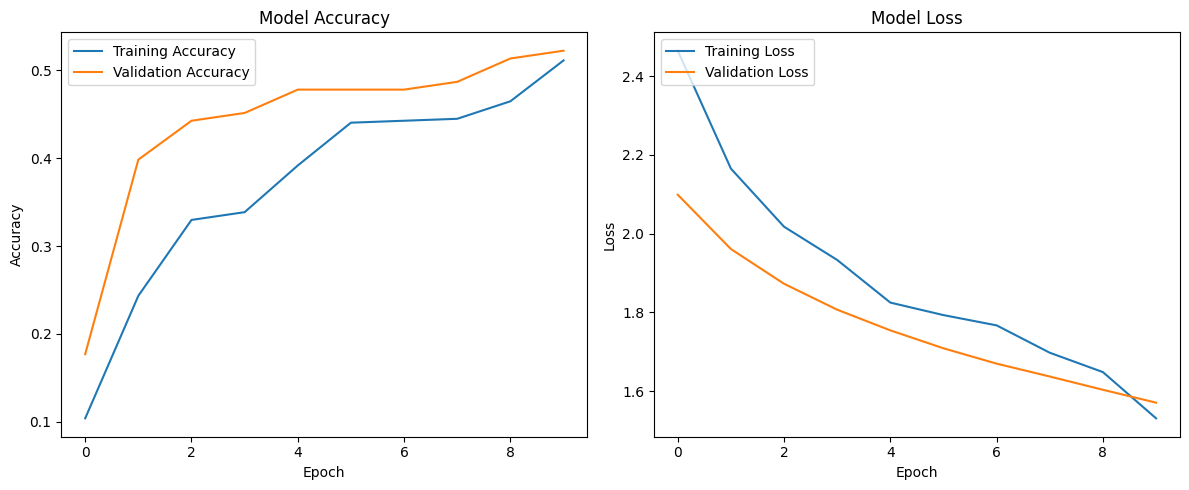

In [8]:
# Step 8: Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Training Progress: 100%|██████████████████████████████████████████████████████████████| 9/9 [1:42:29<00:00, 683.31s/it]


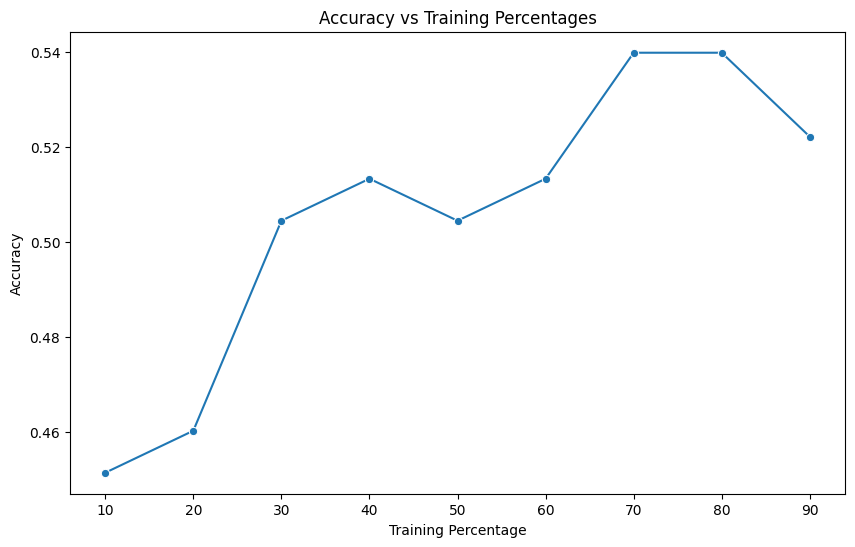

In [9]:
# Step 9: Evaluate model performance on different training set sizes
training_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
accuracies = []

for percent in tqdm(training_percentages, desc="Training Progress"):
    X_train_partial, _, y_train_partial, _ = train_test_split(X_train, y_train, test_size=(100-percent)/100, random_state=42)
    train_encodings_partial = tokenizer(X_train_partial['utterance'].tolist(), truncation=True, padding='max_length', max_length=128)
    train_dataset_partial = tf.data.Dataset.from_tensor_slices(
        (dict(train_encodings_partial), X_train_partial['speaker'], X_train_partial['KMeans_Cluster'], y_train_partial)).batch(16)
    
    model_partial = tf.keras.models.clone_model(model)
    model_partial.set_weights(model.get_weights())
    
    # Create a new optimizer for the cloned model
    optimizer_partial = tf.keras.optimizers.Adam(learning_rate=5e-5)
    model_partial.compile(optimizer=optimizer_partial, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Prepare the dataset with speaker inputs and EM_Cluster dimensions
    train_dataset_partial = tf.data.Dataset.from_tensor_slices(
        (dict(train_encodings_partial), X_train_partial['speaker'], X_train_partial['KMeans_Cluster'], y_train_partial)).batch(16)
    train_dataset_partial = train_dataset_partial.map(map_fn)
    
    history_partial = model_partial.fit(train_dataset_partial, epochs=5, validation_data=test_dataset, verbose=0)
    eval_results_partial = model_partial.evaluate(test_dataset, verbose=0)
    accuracies.append(eval_results_partial[1])

# Plot accuracy vs training percentages
plt.figure(figsize=(10, 6))
sns.lineplot(x=training_percentages, y=accuracies, marker='o')
plt.title('Accuracy vs Training Percentages')
plt.xlabel('Training Percentage')
plt.ylabel('Accuracy')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 124s 12s/step


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


8/8 ━━━━━━━━━━━━━━━━━━━━ 84s 7s/step


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


8/8 ━━━━━━━━━━━━━━━━━━━━ 100s 12s/step


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


8/8 ━━━━━━━━━━━━━━━━━━━━ 95s 9s/step


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


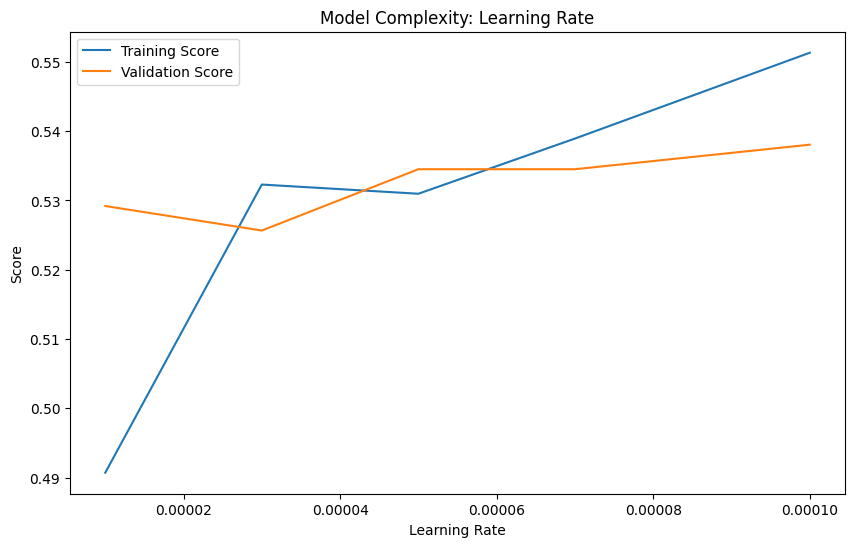

Learning Rate Metrics:
   Learning Rate  Training Time (s)  Test Accuracy  Test Precision  \
0        0.00001        1005.637996       0.530973        0.378106   
1        0.00003        1004.343472       0.530973        0.361944   
2        0.00005        1010.245774       0.530973        0.361773   
3        0.00007        1033.230595       0.539823        0.366049   
4        0.00010         946.575248       0.530973        0.404320   

   Test Recall  Test F1 Score  Test Loss  
0     0.530973       0.414589   1.543443  
1     0.530973       0.415612   1.494105  
2     0.530973       0.415693   1.441846  
3     0.539823       0.430835   1.406747  
4     0.530973       0.431510   1.358356  


In [10]:
# Step 10: Model Complexity Graphs (Validation Curves) 
# Function to plot model complexity graphs
def plot_model_complexity(param_name, param_range, train_scores, test_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
    plt.title(f'Model Complexity: {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.show()

# Example: Varying the learning rate
learning_rates = [1e-5, 3e-5, 5e-5, 7e-5, 1e-4]
train_scores = []
test_scores = []
learning_rate_metrics = []

for lr in learning_rates:
    model_lr = tf.keras.models.clone_model(model)
    model_lr.set_weights(model.get_weights())
    
    optimizer_lr = tf.keras.optimizers.Adam(learning_rate=lr)
    model_lr.compile(optimizer=optimizer_lr, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    start_time = time.time()
    history_lr = model_lr.fit(train_dataset, epochs=5, validation_data=test_dataset, verbose=0)
    training_time_lr = time.time() - start_time
    
    eval_results_lr = model_lr.evaluate(test_dataset, verbose=0)
    predictions_lr = model_lr.predict(test_dataset)
    pred_labels_lr = np.argmax(predictions_lr, axis=1)
    
    accuracy_lr = accuracy_score(y_test, pred_labels_lr)
    precision_lr = precision_score(y_test, pred_labels_lr, average='weighted')
    recall_lr = recall_score(y_test, pred_labels_lr, average='weighted')
    f1_lr = f1_score(y_test, pred_labels_lr, average='weighted')
    
    train_scores.append(history_lr.history['accuracy'])
    test_scores.append(history_lr.history['val_accuracy'])
    
    learning_rate_metrics.append({
        'Learning Rate': lr,
        'Training Time (s)': training_time_lr,
        'Test Accuracy': accuracy_lr,
        'Test Precision': precision_lr,
        'Test Recall': recall_lr,
        'Test F1 Score': f1_lr,
        'Test Loss': eval_results_lr[0]
    })

plot_model_complexity('Learning Rate', learning_rates, train_scores, test_scores)

# Generate a table with learning rate metrics
df_learning_rate_metrics = pd.DataFrame(learning_rate_metrics)
print("Learning Rate Metrics:")
print(df_learning_rate_metrics)